In [13]:
%%file finetune.py
# Fine tune.
from constant import *
import os
import numpy as np
import time
import cPickle
from pylab import *
import argparse

#### Parameters ####
parser = argparse.ArgumentParser()
parser.add_argument('--gpu', default=0, required=False)
parser.add_argument('--model_name', required=True)
parser.add_argument('--model_type_str', required=True) # crop / nocrop / aperture
args = parser.parse_args()
gpu = int(args.gpu)
model_name = args.model_name
model_type_str = args.model_type_str

'''
gpu = 0
model_name = '0'
model_type_str = '1k_nocrop_obj'
'''

####################

import caffe

niter = 30000
# Losses will also be stored in the log.
train_loss = np.zeros(niter)
train_accuracy = np.zeros(niter)
test_accuracy = {}

caffe.set_device(gpu)
caffe.set_mode_gpu()

print 'Processing: finetune_alexnet_{}_{}'.format(model_type_str, model_name), 'on GPU', gpu, ',', model_type_str

solver = caffe.SGDSolver(result_root + 'model/finetune_alexnet_{}_{}/solver.prototxt'.format(model_type_str, model_name))
solver.net.copy_from(result_root + 'model/bvlc_alexnet/bvlc_alexnet.caffemodel')

start_time = time.time()
# We run the solver for niter times, and record the training loss.
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    train_loss[it] = solver.net.blobs['loss'].data
    train_accuracy[it] = solver.net.blobs['accuracy_train'].data
    second = int(time.time() - start_time)
    estimated = int(float(niter) / (it + 1) * second)
    estimated_day = estimated / 3600 / 24
    now_time = time.strftime("%H:%M:%S", time.gmtime(second))
    estimated_time = time.strftime("%H:%M:%S", time.gmtime(estimated))
    if it % 100 == 0 or (it <= 1000 and it % 10 == 0):
        test_iters = 10
        accuracy = 0
        for i in arange(test_iters):
            solver.test_nets[0].forward()
            accuracy += solver.test_nets[0].blobs['accuracy_test'].data
        accuracy /= test_iters
        test_accuracy[it] = accuracy
        print '[{} / {}d {}] iter{:6} | train_loss={:10.6f}, train_accuracy={:10.6f}, test_accuracy={:10.6f}'.format(now_time, estimated_day, estimated_time, it, float(train_loss[it]), float(train_accuracy[it]), accuracy)
    elif it % 10 == 0:
        print '[{} / {}d {}] iter{:6} | train_loss={:10.6f}, train_accuracy={:10.6f}'.format(now_time, estimated_day, estimated_time, it, float(train_loss[it]), float(train_accuracy[it]))
        
solver.net.save(result_root + 'model/finetune_alexnet_{}_{}/finetune_alexnet_{}_{}.caffemodel'.format(model_type_str, model_name, model_type_str, model_name))

with open(result_root + 'finetune/train_loss_{}_{}.pickle'.format(model_type_str, model_name), 'wb') as f:
    cPickle.dump(train_loss, f)
with open(result_root + 'finetune/train_accuracy_{}_{}.pickle'.format(model_type_str, model_name), 'wb') as f:
    cPickle.dump(train_accuracy, f)
with open(result_root + 'finetune/test_accuracy_{}_{}.pickle'.format(model_type_str, model_name), 'wb') as f:
    cPickle.dump(test_accuracy, f)

print 'done'

Overwriting finetune.py


In [11]:
# Create network files.
import os
from constant import *

type_strs = ['1k_nocrop_obj', '1k_crop_obj']
#net_names = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100' 'all']
net_names = ['0', '20', '40', '60', '80', '100', 'all']

#with open(result_root + 'model/finetune_alexnet_1k_prototype/deploy.prototxt') as f:
#    deploy_lines = f.readlines()
with open(result_root + 'model/finetune_alexnet_1k_prototype/solver.prototxt') as f:
    solver_lines = f.readlines()
with open(result_root + 'model/finetune_alexnet_1k_prototype/train_val.prototxt') as f:
    train_val_lines = f.readlines()

for type_str in type_strs:
    for net_name in net_names:
        folder = '{}model/finetune_alexnet_{}_{}/'.format(result_root, type_str, net_name)
        if not os.path.exists(folder):
            os.makedirs(folder)
        solver_lines[0] = 'net: "{}model/finetune_alexnet_{}_{}/train_val.prototxt"\n'.format(result_root, type_str, net_name)
        solver_lines[12] = 'snapshot_prefix: "{}model/finetune_alexnet_{}_{}/snapshot"\n'.format(result_root, type_str, net_name)
        train_val_lines[15] = '    source: "{}lmdb/train_{}_{}"\n'.format(imagenet_root, type_str, net_name)
        train_val_lines[34] = '    source: "{}lmdb/test_{}_{}"\n'.format(imagenet_root, type_str, net_name)
        #with open(folder + 'deploy.prototxt', 'w') as f:
        #    f.writelines(deploy_lines)
        with open(folder + 'solver.prototxt', 'w') as f:
            f.writelines(solver_lines)
        with open(folder + 'train_val.prototxt', 'w') as f:
            f.writelines(train_val_lines)
    

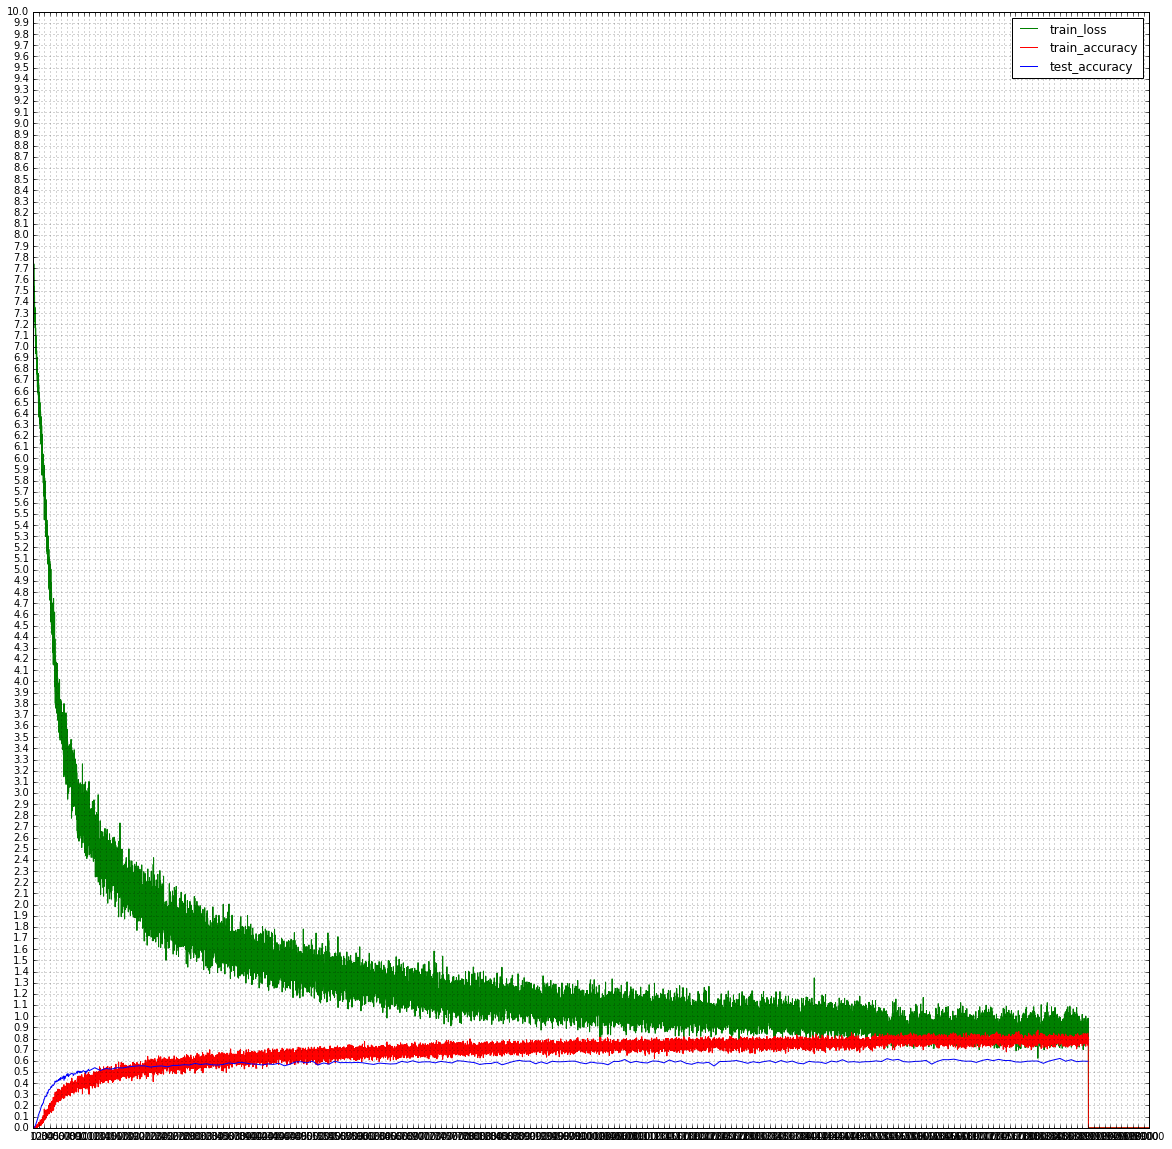

In [9]:
# Visualize middle results.
from constant import *
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import cPickle
%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 20)

x_range = [0, 20000]
x_unit = 100

y_range = [0, 10]
y_unit = 0.1

# Curves.
plt.plot(train_loss, zorder = 0, color = 'g')
plt.plot(train_accuracy, zorder = 1, color = 'r')
keys = sorted(test_accuracy.keys())
values = [test_accuracy[key] for key in keys]
plt.plot(keys, values, zorder = 2, color = 'b')
plt.legend(['train_loss', 'train_accuracy', 'test_accuracy'], loc='upper right')

# Grid.
ax = plt.gca()
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_xticks(np.arange(x_range[0], x_range[1] + x_unit, x_unit))                                                       
ax.set_xticks(np.arange(x_range[0], x_range[1] + x_unit, x_unit), minor=True)                                           
ax.set_yticks(np.arange(y_range[0], y_range[1] + y_unit, y_unit))                                                       
ax.set_yticks(np.arange(y_range[0], y_range[1] + y_unit, y_unit), minor=True)                                           
ax.grid(which='both')                                                            
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)     

plt.show()